In [ ]:
!pip install patchify

In [ ]:
import os
import zipfile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from skimage import data
from skimage.filters import threshold_multiotsu
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage import img_as_ubyte
from skimage import io, color

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from scipy.fft import fft, fftfreq
from scipy.ndimage import *
from scipy.stats import pearsonr

import pywt

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm
import tifffile as tiff

from patchify import patchify
from PIL import Image

import prepare_utils

# Uploads Data

In [ ]:
input_image = Image.open('rec_00400.tif')

input_matrix = np.array(input_image)

In [ ]:
input_matrix.shape

(2615, 2615)

In [ ]:
res = Image.open('Label_400_final.tif')

output_martix = np.array(res)
output_martix.shape

(2615, 2615)

# Preprocess Data

In [ ]:
filenames = ['rec_00400.tif']
dir_path = ''

In [ ]:
# cut the mask
def prepare_data(data):
    data_blur, sobelx, sobely = prepare_utils.calculate(data,
                                                    half_size=data.shape[0] // 2,
                                                    kernel_size=15,
                                                    radius=1230,
                                                    even_number=True)
    sobelx = prepare_utils.std_scaler(sobelx)
    sobely = prepare_utils.std_scaler(sobely)
    full_image_test = np.stack((data_blur, sobelx, sobely), axis=2)
    full_image_test = np.reshape(full_image_test, newshape=(1,) + full_image_test.shape)
    return full_image_test

In [ ]:
# separate by fragments
test_data_list = []
for i in tqdm(range(len(filenames))):
    file = tiff.imread(os.path.join(dir_path, filenames[0]))
    full_image_i = prepare_data(file[::4, ::4])
    test_data_list.append(full_image_i)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
test_data_array = np.vstack(test_data_list)
test_data_array.shape

(1, 654, 654, 3)

<Axes: >

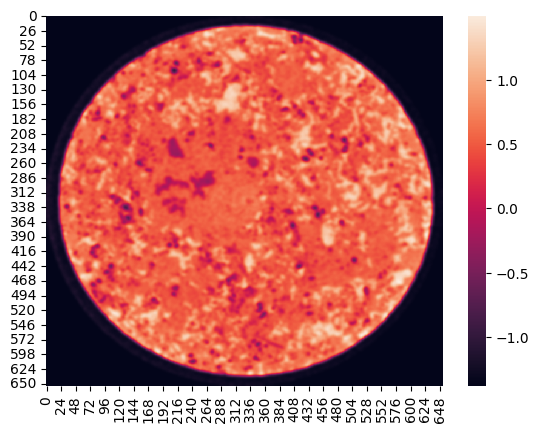

In [ ]:
image_to_visualize = test_data_array[0]
sns.heatmap(test_data_array[0, :, :, 0])

In [ ]:
# true
filenames = ['Label_400_final.tif']
dir_path = ''

test_data_list = []
for i in tqdm(range(len(filenames))):
    file = tiff.imread(os.path.join(dir_path, filenames[0]))
    full_image_i = prepare_data(file[::4, ::4])
    test_data_list.append(full_image_i)

true_data = np.vstack(test_data_list)
true_data.shape

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 654, 654, 3)

<Axes: >

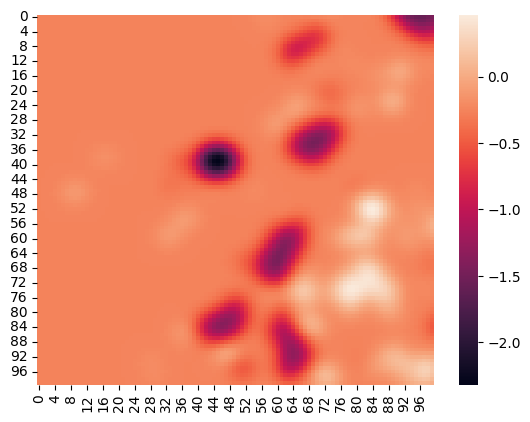

In [ ]:
sns.heatmap(true_data[0, 288:388, 288:388, 0])

In [ ]:
test_data_array[:, :, :, 0].shape

(1, 654, 654)

## Augmentation

In [ ]:
def image_rotate(image, d_a):
    angles = np.arange(0, 350 + d_a, d_a)
    r_img_list = []
    for angle in angles:
        r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
        r_img_list.append(r_img)
    return r_img_list
def data_rotate(data, d_a):
    data_list = []
    for i in tqdm(range(data.shape[0])):
        data_j_list = []
        for j in range(data.shape[1]):
            data_j_list += image_rotate(data[i, j], d_a)
        data_list += data_j_list
    rotated_data = np.asarray(data_list)
    return rotated_data

In [ ]:
test_data_list = []
filenames = ['rec_00400.tif']

for i in tqdm(range(len(filenames))):
    f = tiff.imread(os.path.join(dir_path, filenames[0]))
    full_image_i = prepare_data(f[1:, 1:])

data_cut_array = patchify(test_data_array[i, :, :,  0], (128, 128), step=128)
sobelx_cut_array = patchify(test_data_array[i, :, :,  0], (128, 128), step=128)
sobely_cut_array = patchify(test_data_array[i, :, :,  0], (128, 128), step=128)

label_cut_array = patchify(label, (128, 128), step=128)

In [ ]:
# rotate
rotated_cut_images = data_rotate(data_cut_array, d_a=10)
rotated_sobelx_images = data_rotate(sobelx_cut_array, d_a=10)
rotated_sobely_images = data_rotate(sobely_cut_array, d_a=10)

rotated_label_images = data_rotate(label_cut_array, d_a=10)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
X = np.stack((rotated_cut_images, rotated_sobelx_images, rotated_sobely_images), axis=3)

X_train, X_test, y_train, y_test = train_test_split(X, rotated_label_images, test_size=0.65, random_state=42)

# AI models

## Fully CNN

In [ ]:
class FCNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Middle (Bottleneck)
        self.middle = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=2),
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

## U-net

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder - 1
        self.enc_conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.enc_relu1 = nn.ReLU(inplace=True)

        self.enc_conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.enc_relu2 = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder - 2
        self.enc2_conv1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1)
        self.enc2_relu1 = nn.ReLU(inplace=True)

        self.enc2_conv2 = nn.Conv2d(in_channels//2, in_channels//2, kernel_size=3, padding=1)
        self.enc2_relu2 = nn.ReLU(inplace=True)

        # Decoder - 2
        self.dec2_conv1 = nn.Conv2d(in_channels//2, in_channels, kernel_size=3, padding=1)
        self.dec2_relu1 = nn.ReLU(inplace=True)

        self.dec2_conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.dec2_relu2 = nn.ReLU(inplace=True)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')

        # Decoder - 1
        self.dec_conv1 = nn.Conv2d(4, out_channels, kernel_size=3, padding=1)
        self.dec_relu1 = nn.ReLU(inplace=True)

        self.dec_conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.dec_relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        # print(f'{x.shape}: start')
        # Encoder-1
        x = self.enc_conv1(x)
        x = self.enc_relu1(x)

        x = self.enc_conv2(x)
        x_l1 = self.enc_relu2(x)

        x_enc = self.maxpool(x_l1)

        # Encoder-2
        x = self.enc2_conv1(x_enc)
        x = self.enc2_relu1(x)

        x = self.enc2_conv2(x)
        x = self.enc2_relu2(x)

        x_enc = self.maxpool(x)

        # Decoder-2
        x = self.dec2_conv1(x_enc)
        x = self.dec2_relu1(x)
        x = self.upsample2(x)

        x = self.dec2_conv2(x)
        x = self.dec2_relu2(x)
        x = self.upsample2(x)

        # Decoder-1
        x = torch.cat([x_l1, x], dim=1)
        x = self.dec_conv1(x)
        x = self.dec_relu1(x)

        x = self.dec_conv2(x)
        x = self.dec_relu2(x)

        return x


# Train models

In [ ]:
try:
  X_tensor = torch.from_numpy(X_train).float()
  y_tensor = torch.from_numpy(y_train).float()
except Exception as e:
  X_tensor = torch.from_numpy(X_train.astype(np.float32))
  y_tensor = torch.from_numpy(y_train.astype(np.float32))

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 32
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

## Usefull function

In [ ]:
def calculate_accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1)
    correct_pixels = torch.eq(predictions, targets).sum().item()
    total_pixels = targets.numel()
    accuracy = correct_pixels / total_pixels
    return accuracy

def calculate_iou(predictions, targets):
    intersection = torch.logical_and(targets, predictions).sum().item()
    union = torch.logical_or(targets, predictions).sum().item()
    iou = intersection / union
    return iou

def log_metrics(phase, epoch, loss, accuracy, iou):
    print(f'{phase}_loss', loss, epoch)
    print(f'{phase}_accuracy', accuracy, epoch)
    print(f'{phase}_iou', iou, epoch)

def train(model, train_loader, criterion, optimizer, epoch, log_metrics, save_folder):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    total_iou = 0.0

    for ep in tqdm(range(1, epoch+1)):
      for (inputs, targets) in tqdm(train_loader):
          inputs = inputs.unsqueeze(0).permute(0, 3, 1, 2)
          targets = targets.unsqueeze(0).unsqueeze(-1).permute(0, 3, 1, 2)

          optimizer.zero_grad()
          outputs = model(inputs)

          loss = criterion(outputs[0, 0, :, :], targets[0, 0, :, :])
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          accuracy = calculate_accuracy(outputs, targets)
          total_accuracy += accuracy
          iou = calculate_iou(outputs, targets)
          total_iou += iou

    average_loss = total_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)
    average_iou = total_iou / len(train_loader)

    log_metrics('train', epoch, average_loss, average_accuracy, average_iou)

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    save_path = f"{save_folder}/model_epoch_{epoch}.pt"
    torch.save(model.state_dict(), save_path)

    return save_path

def validate(model, val_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    total_iou = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            accuracy = calculate_accuracy(outputs, targets)
            total_accuracy += accuracy
            iou = calculate_iou(outputs, targets)
            total_iou += iou

    average_loss = total_loss / len(val_loader)
    average_accuracy = total_accuracy / len(val_loader)
    average_iou = total_iou / len(val_loader)

    log_metrics('val', epoch, average_loss, average_accuracy, average_iou)


In [ ]:
def visualize_random_sample(model, train_loader):
    random_index = np.random.randint(len(train_loader.dataset))
    sample = train_loader.dataset[random_index]

    input_image, target_mask = sample[0], sample[1]

    input_image = input_image.unsqueeze(0).permute(0, 3, 1, 2)
    target_mask = target_mask.unsqueeze(0).unsqueeze(-1).permute(0, 3, 1, 2)

    model.eval()
    with torch.no_grad():
        predicted_mask = model(input_image)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image.squeeze().permute(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(target_mask.squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

## Fully CNN

In [ ]:
%%time
# train FCNN
EPOCH = 1

model_fcnn = FCNN(3, 1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.001)
log_metrics = lambda *args: print(args)

train(model_fcnn, dataset, criterion, optimizer, EPOCH, log_metrics, 'fcnn')

('train', 1, 0.0, 0.0, 0.0)
CPU times: user 8.6 ms, sys: 0 ns, total: 8.6 ms
Wall time: 37.4 ms


'fcnn/model_epoch_1.pt'

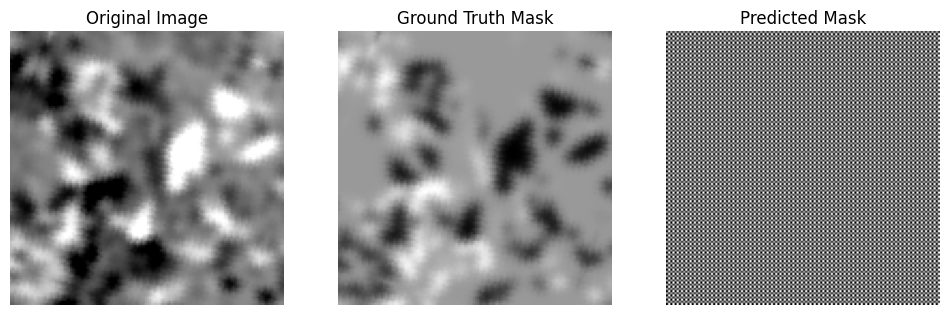

CPU times: user 426 ms, sys: 98.5 ms, total: 524 ms
Wall time: 414 ms


In [ ]:
%%time
visualize_random_sample(model_fcnn, train_loader)

In [ ]:
%%time
# train FCNN
EPOCH = 40

model_fcnn = FCNN(3, 1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.001)
log_metrics = lambda *args: print(args)

train(model_fcnn, dataset, criterion, optimizer, EPOCH, log_metrics, 'fcnn')

Epoch 40:   0%|          | 0/315 [00:00<?, ?it/s]

('train', 40, -35.677906066652326, 0.0, 1.0)
CPU times: user 17.3 s, sys: 108 ms, total: 17.4 s
Wall time: 17.9 s


'fcnn/model_epoch_40.pt'

## u-net train

In [ ]:
# train Unet
EPOCH = 10000

model_unet = UNet(3, 1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_unet.parameters(), lr=0.001)
log_metrics = lambda *args: print(args)

train(model_unet, dataset, criterion, optimizer, EPOCH, log_metrics, 'u_net')

Epoch 10000:   0%|          | 0/315 [00:00<?, ?it/s]

('train', 10000, -35.65752955845424, 0.0, 2.4026537698412698e-05)


'u_net/model_epoch_10000.pt'

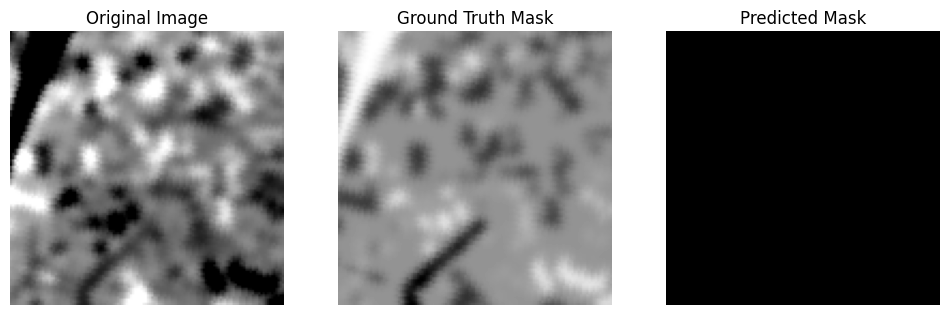

In [ ]:
visualize_random_sample(model_unet, train_loader)